In [0]:
import pandas as pd
import numpy as np
import warnings
from matplotlib import pyplot
#from pandas import read_csv, set_option
from pandas import Series
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import random
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from xgboost import XGBClassifier
import xgboost as xgb
import seaborn as sns
import datetime
from tqdm import tqdm_notebook as tqdm

**Data Preparation:**

Loading tables and checking top 5 elements.

In [0]:
prices = pd.read_csv('prices2.csv')
prices.head()

,Time,year,bitcoin,ripple,ethereum,bitcoin_cash,eos,stellar,tether,litecoin,tron,bitcoin_sv,cardano,iota,binance_coin,monero,dash,nem,neo,ethereum_classic,usd_coin,zcash,maker,waves,tezos,dogecoin,vechain,bitcoin_gold,trueusd,ontology,qtum,omisego,zilliqa,basic_attention_token,x0x,decred,chainlink,lisk,paxos_standard_token,bitcoin_diamond,...,zb,infinity_economics,abbc_coin,know,hycon,bumo,filecoin,machine_xchange_coin,platincoin,project_pai,davinci_coin,playcoin,lambda,almeela,e_chat,edu_coin,digifinextoken,atlas_protocol,hyperquant,content_value_network,super_bitcoin,shinechain,volt,thingsoperatingsystem,game_stars,mir_coin,bitcoiin,starchain,lightning_bitcoin,stronghold_usd,molecular_future,carat,hitchain,fiii,ether_zero,fairgame,beekan,cwv_chain,ong,dipnet
0,Apr 28,2013,134.21,NaN,NaN,NaN,NaN,NaN,NaN,4.35,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Apr 29,2013,144.54,NaN,NaN,NaN,NaN,NaN,NaN,4.38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Apr 30,2013,139.00,NaN,NaN,NaN,NaN,NaN,NaN,4.30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,May 1,2013,116.99,NaN,NaN,NaN,NaN,NaN,NaN,3.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,May 2,2013,105.21,NaN,NaN,NaN,NaN,NaN,NaN,3.37,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
marketcaps = pd.read_csv('marketcaps2.csv')
marketcaps.head()

,Time,year,bitcoin,ripple,ethereum,bitcoin_cash,eos,stellar,tether,litecoin,tron,bitcoin_sv,cardano,iota,binance_coin,monero,dash,nem,neo,ethereum_classic,usd_coin,zcash,maker,waves,tezos,dogecoin,vechain,bitcoin_gold,trueusd,ontology,qtum,omisego,zilliqa,basic_attention_token,x0x,decred,chainlink,lisk,paxos_standard_token,bitcoin_diamond,...,zb,infinity_economics,abbc_coin,know,hycon,bumo,filecoin,machine_xchange_coin,platincoin,project_pai,davinci_coin,playcoin,lambda,almeela,e_chat,edu_coin,digifinextoken,atlas_protocol,hyperquant,content_value_network,super_bitcoin,shinechain,volt,thingsoperatingsystem,game_stars,mir_coin,bitcoiin,starchain,lightning_bitcoin,stronghold_usd,molecular_future,carat,hitchain,fiii,ether_zero,fairgame,beekan,cwv_chain,ong,dipnet
0,Apr 28,2013,1488566728,NaN,NaN,NaN,NaN,NaN,NaN,74636938,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Apr 29,2013,1603768865,NaN,NaN,NaN,NaN,NaN,NaN,75388964,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Apr 30,2013,1542813125,NaN,NaN,NaN,NaN,NaN,NaN,74020918,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,May 1,2013,1298954594,NaN,NaN,NaN,NaN,NaN,NaN,65604596,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,May 2,2013,1168517495,NaN,NaN,NaN,NaN,NaN,NaN,58287979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
marketshares = pd.read_csv('marketshares.csv')
marketshares.head()

,Time,year,bitcoin,ripple,ethereum,bitcoin_cash,eos,stellar,tether,litecoin,tron,bitcoin_sv,cardano,iota,binance_coin,monero,dash,nem,neo,ethereum_classic,usd_coin,zcash,maker,waves,tezos,dogecoin,vechain,bitcoin_gold,trueusd,ontology,qtum,omisego,zilliqa,basic_attention_token,x0x,decred,chainlink,lisk,paxos_standard_token,bitcoin_diamond,...,zb,infinity_economics,abbc_coin,know,hycon,bumo,filecoin,machine_xchange_coin,platincoin,project_pai,davinci_coin,playcoin,lambda,almeela,e_chat,edu_coin,digifinextoken,atlas_protocol,hyperquant,content_value_network,super_bitcoin,shinechain,volt,thingsoperatingsystem,game_stars,mir_coin,bitcoiin,starchain,lightning_bitcoin,stronghold_usd,molecular_future,carat,hitchain,fiii,ether_zero,fairgame,beekan,cwv_chain,ong,dipnet
0,Apr 28,2013,0.000019,NaN,NaN,NaN,NaN,NaN,NaN,0.000022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Apr 29,2013,0.000020,NaN,NaN,NaN,NaN,NaN,NaN,0.000022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Apr 30,2013,0.000019,NaN,NaN,NaN,NaN,NaN,NaN,0.000022,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,May 1,2013,0.000016,NaN,NaN,NaN,NaN,NaN,NaN,0.000019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,May 2,2013,0.000015,NaN,NaN,NaN,NaN,NaN,NaN,0.000017,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
rank = pd.read_csv('rank.csv')
rank.head()

,Time,year,bitcoin,ripple,ethereum,bitcoin_cash,eos,stellar,tether,litecoin,tron,bitcoin_sv,cardano,iota,binance_coin,monero,dash,nem,neo,ethereum_classic,usd_coin,zcash,maker,waves,tezos,dogecoin,vechain,bitcoin_gold,trueusd,ontology,qtum,omisego,zilliqa,basic_attention_token,x0x,decred,chainlink,lisk,paxos_standard_token,bitcoin_diamond,...,zb,infinity_economics,abbc_coin,know,hycon,bumo,filecoin,machine_xchange_coin,platincoin,project_pai,davinci_coin,playcoin,lambda,almeela,e_chat,edu_coin,digifinextoken,atlas_protocol,hyperquant,content_value_network,super_bitcoin,shinechain,volt,thingsoperatingsystem,game_stars,mir_coin,bitcoiin,starchain,lightning_bitcoin,stronghold_usd,molecular_future,carat,hitchain,fiii,ether_zero,fairgame,beekan,cwv_chain,ong,dipnet
0,Apr 28,2013,6.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Apr 29,2013,6.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Apr 30,2013,6.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,May 1,2013,6.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,May 2,2013,6.0,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [0]:
volumes = pd.read_csv('volumes.csv')

columns = volumes.columns.values
currencies = columns[2:]



In [0]:
roi = pd.read_csv('ROI.csv')
roi.head()
#print(roi)
#print(roi.shape)
columns = roi.columns.values
#print(columns)
num_currencies = len(columns) - 2
currencies = columns[2:]
#print(currencies)

In [0]:
# create timeline
import datetime
time_col = prices['Time']
year_col = prices['year']
#print(time_col)
#print(year_col)
months = ["nothing",
          "Jan",
          "Feb",
          "Mar",
          "Apr",
          "May",
          "Jun",
          "Jul",
          "Aug",
          "Sep",
          "Oct",
          "Nov",
          "Dec"]
dates = []
for time, year in zip(time_col, year_col):
  s = time.split(' ')
  month = months.index(s[0])
  day = s[1]
  date = datetime.date(year, int(month), int(day))
  dates.append(date)
  #print(date)


In [0]:
import math
def currency_return(dictionary, n, time):
  returns = []
  keys = list(dictionary.keys())
  for t in keys:
    ret = 0
    #print(len(dictionary[t]))
    for i in dictionary[t]:
      ret += i
    returns.append((1/n)*ret)
  return returns

def currency_price(returns, time):
  price = 1
  new = []
  #new.append(price)
  for r in range(len(returns)):
    price = returns[r]*price + price
    new.append(price)
  return new
    

def sharpe_ratio(dictionary, time, n):
  ratios = []
  for i in range(0,time):
    returns = currency_return(dictionary, n, time)
    ret = 0; array=[];
    for j in range(i+1):
      ret += returns[j]
      array.append(returns[j])
    mean = float(ret/(i+1))
    razlika = 0
    for z in range(len(array)):
      razlika += math.pow((array[z]-mean),2)
    if len(array) == 1: 
      ratios.append(0)
    else: 
      std = float(math.sqrt(razlika/(len(array)-1)))
      ratios.append(mean/std)
  return ratios

def geometric_mean(dictionary, time, time_array, n):
  geometric = []
  returns = currency_return(dictionary, n, time)
  plt.figure()
  plt.plot(time_array, returns)
  plt.title("returns")
  plt.show()
  
  cumulative = currency_price(returns, time_array)
  plt.plot(time_array, cumulative)
  plt.title("cumulative return from returns portfolio")
  plt.show()
  
  for i in range(len(returns)):
    suma = 0; n=0;
    for j in range(i+1):
      suma += 1 + returns[j]
      n += 1
    geo = math.pow(suma, 1/float(n))
    geometric.append(geo)
  return geometric
    
  
    
    

In [0]:
def sort_highest_return(dict_return, n):
  keys = dict_return.keys()
  new = dict()
  for t in keys:
    sorted_array = sorted(dict_return[t], reverse=True)
    new[t] = sorted_array[0:n+1]
    #print(sorted_array)
  return new

------ w = 3, W_train = 5 -------


<Figure size 432x288 with 0 Axes>

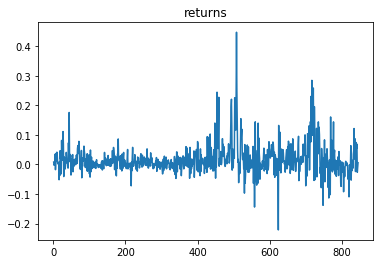

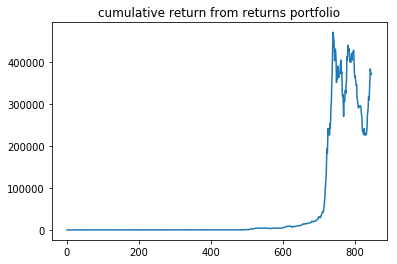

n = 15


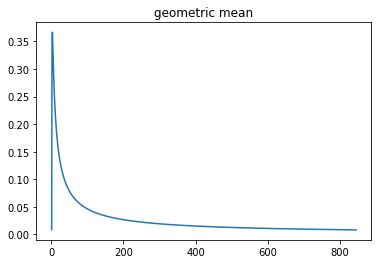

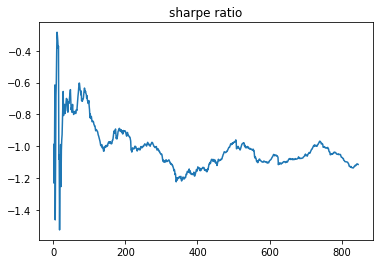

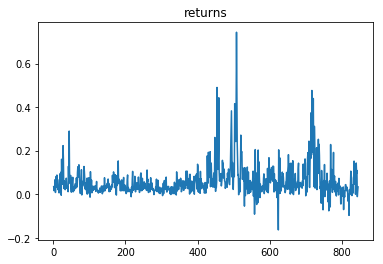

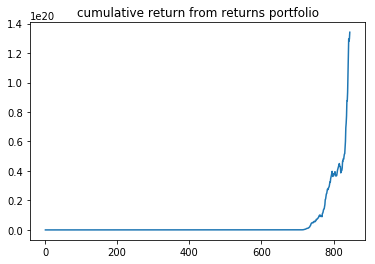

n = 9


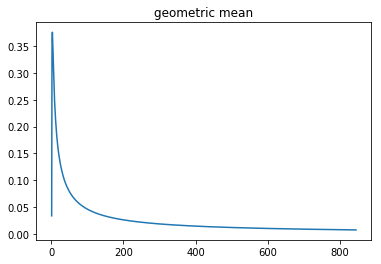

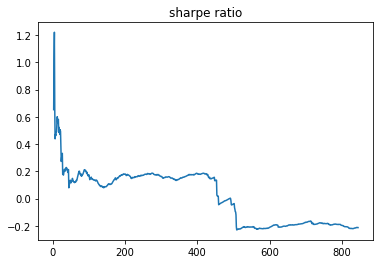

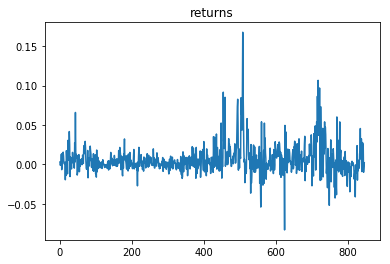

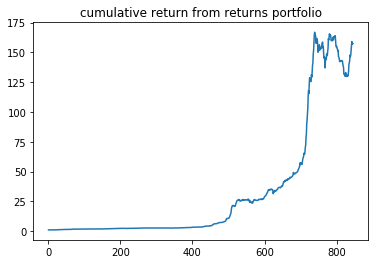

n = 40


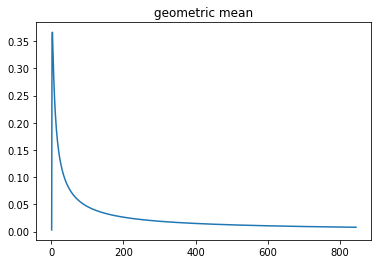

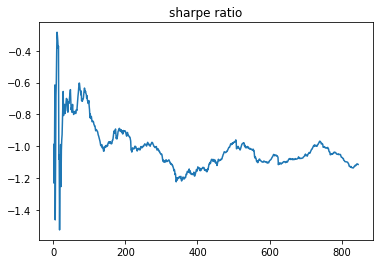

------ w = 3, W_train = 10 -------


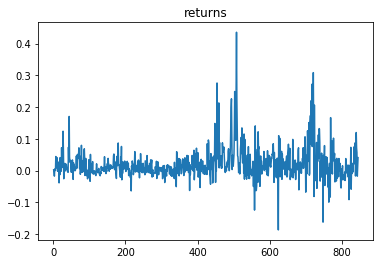

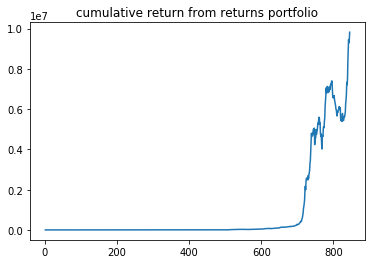

n = 15


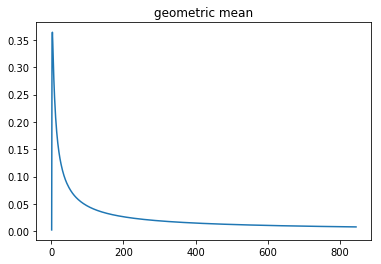

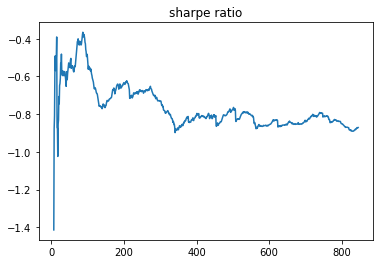

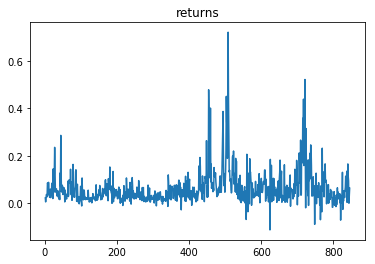

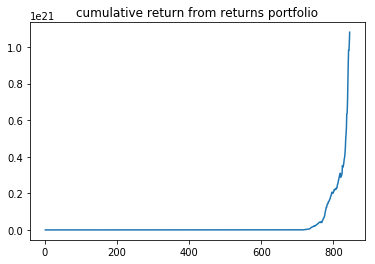

n = 9


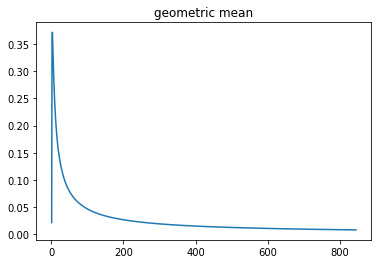

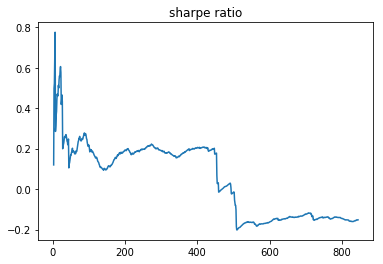

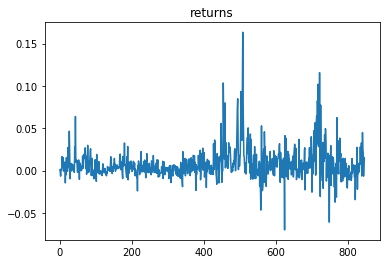

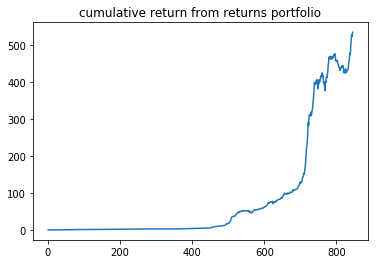

n = 40


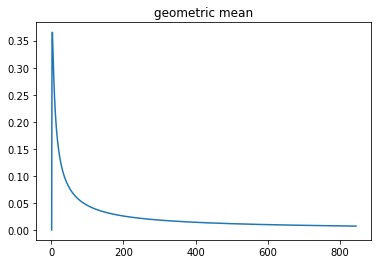

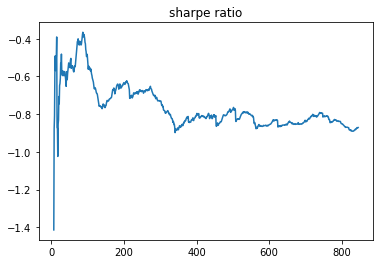

------ w = 3, W_train = 20 -------


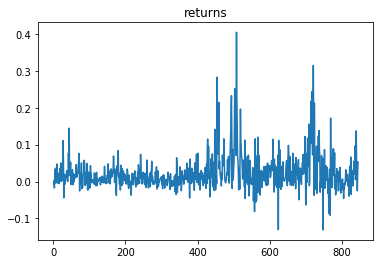

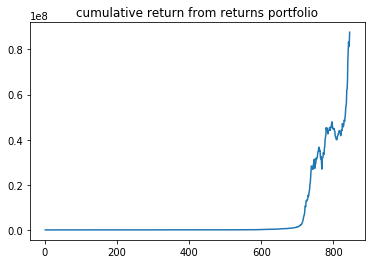

n = 15


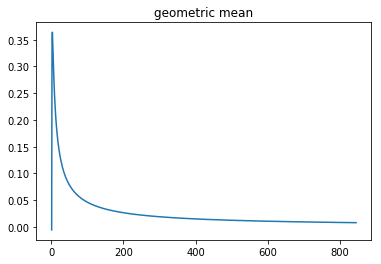

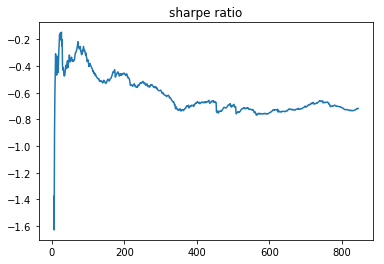

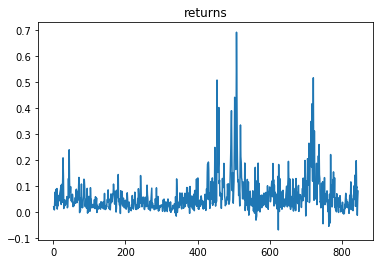

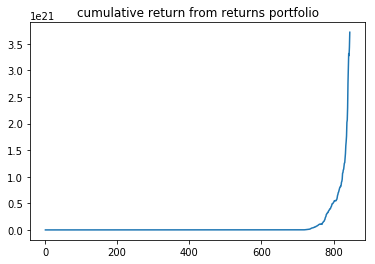

n = 9


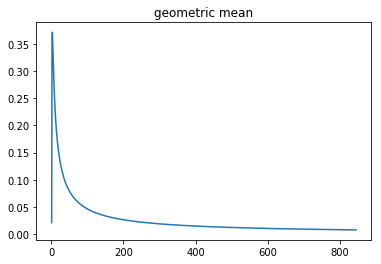

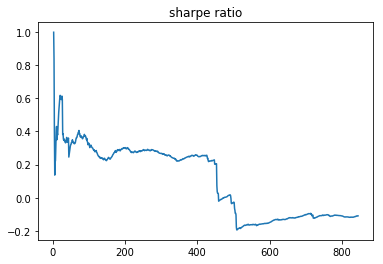

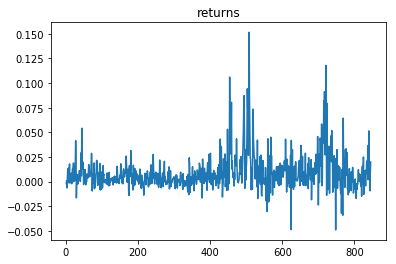

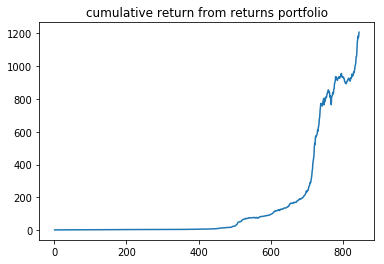

n = 40


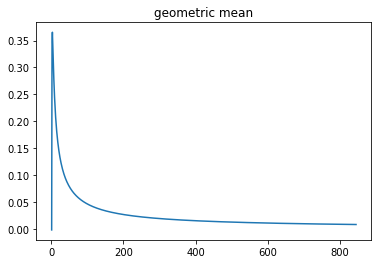

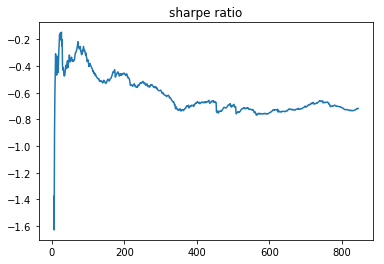

------ w = 5, W_train = 5 -------


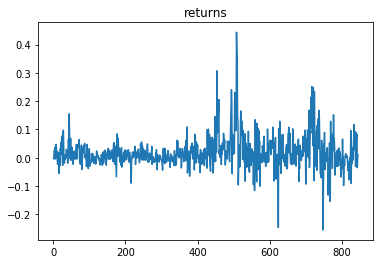

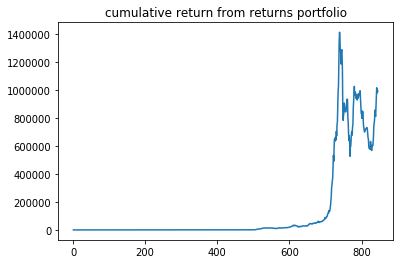

n = 15


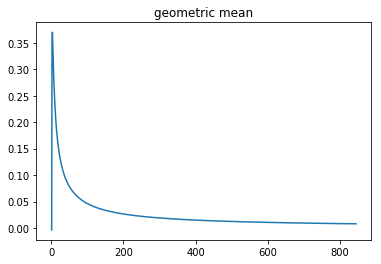

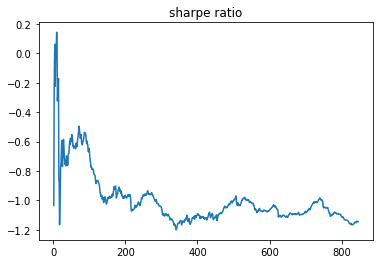

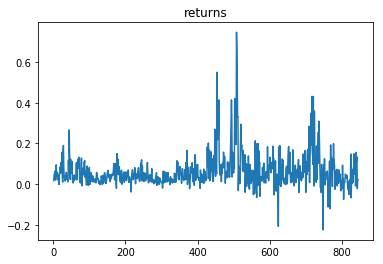

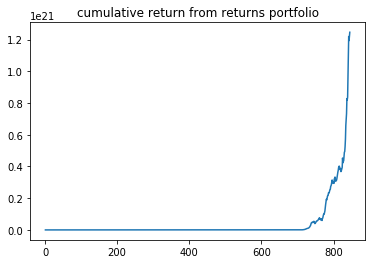

n = 9


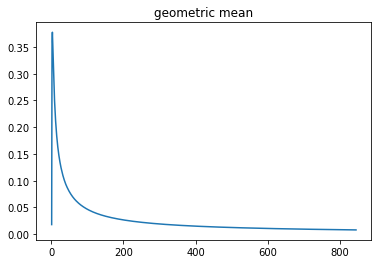

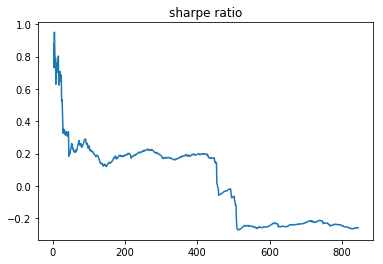

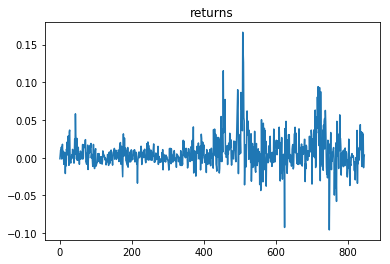

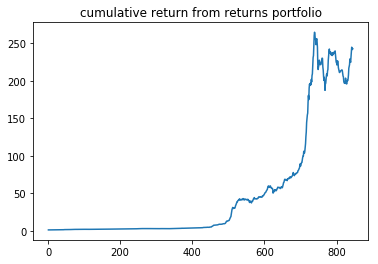

n = 40


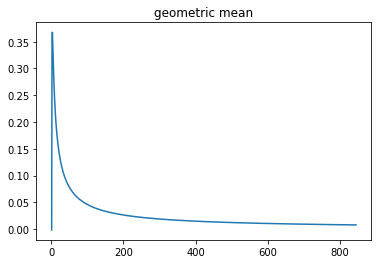

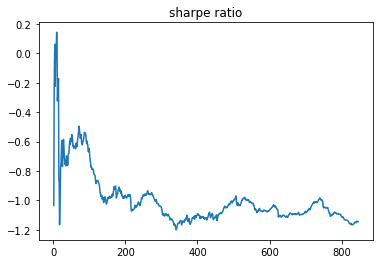

------ w = 5, W_train = 10 -------


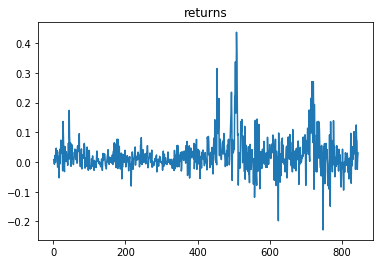

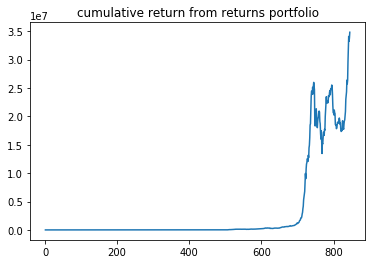

n = 15


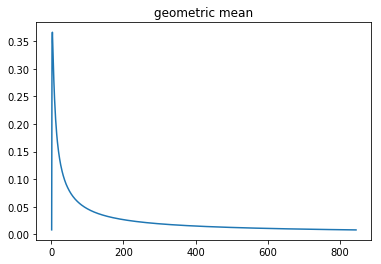

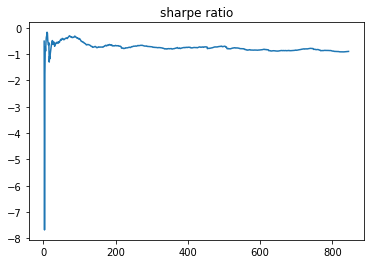

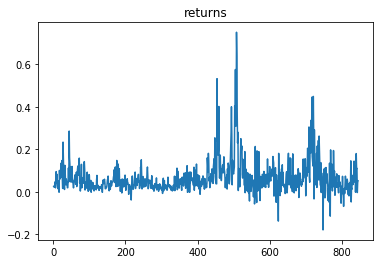

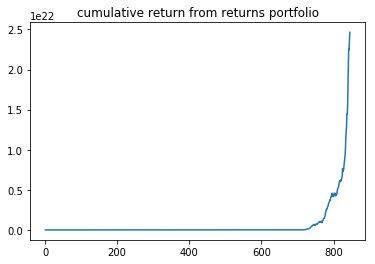

n = 9


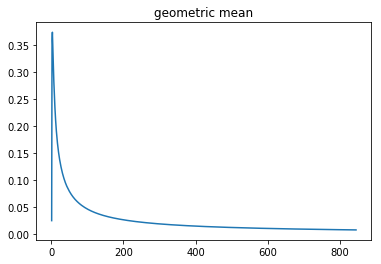

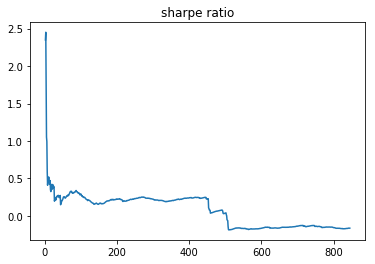

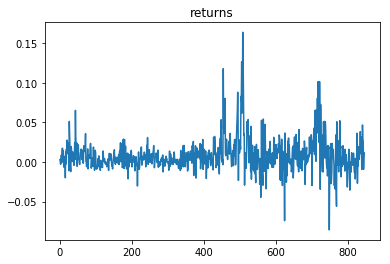

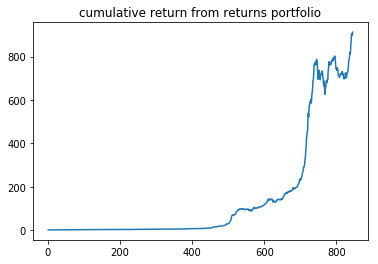

n = 40


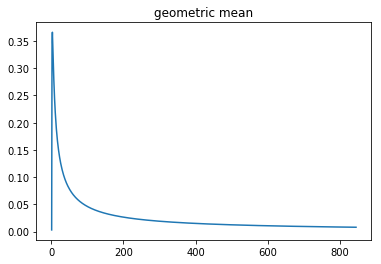

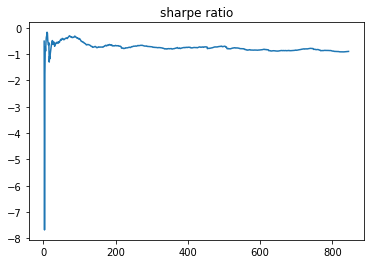

------ w = 5, W_train = 20 -------


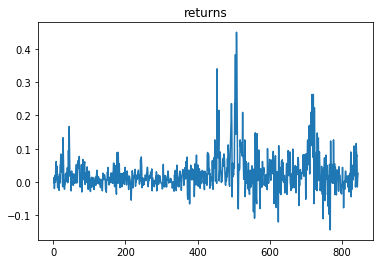

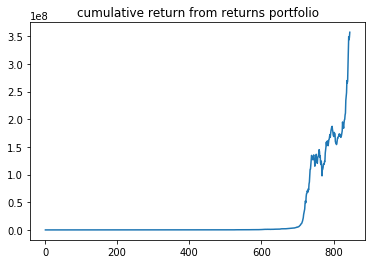

n = 15


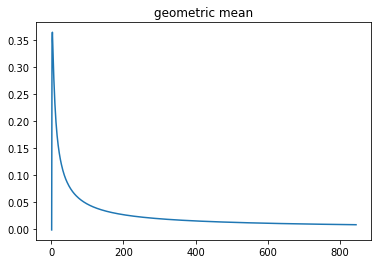

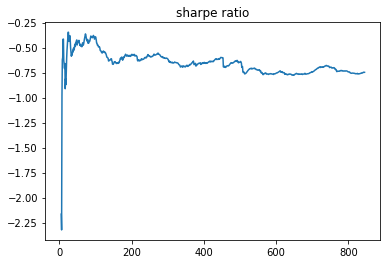

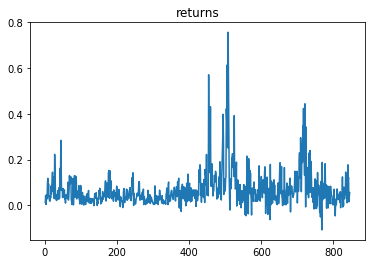

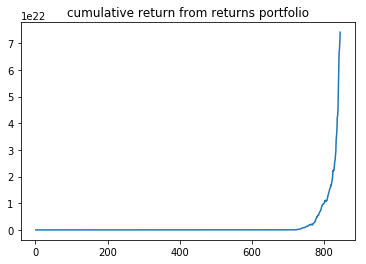

n = 9


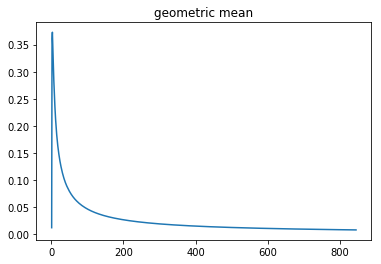

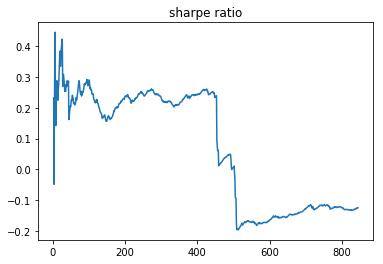

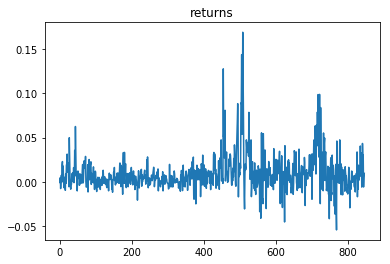

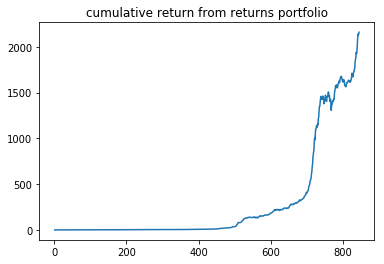

n = 40


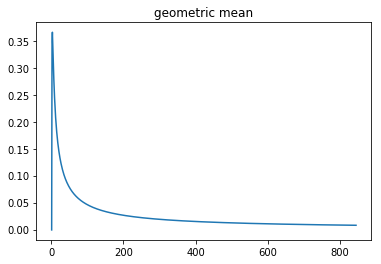

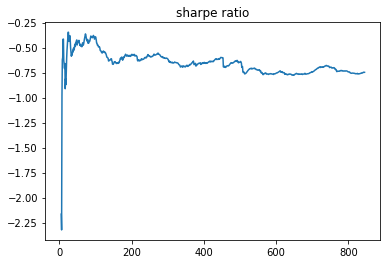

------ w = 7, W_train = 5 -------


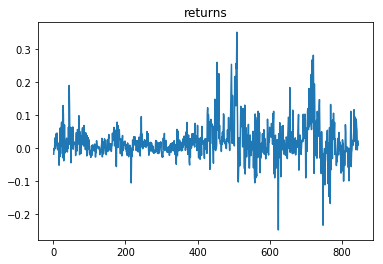

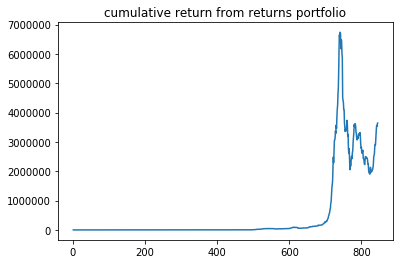

n = 15


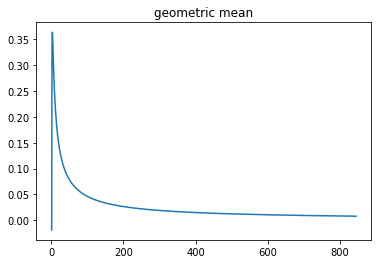

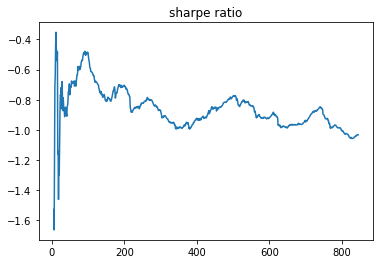

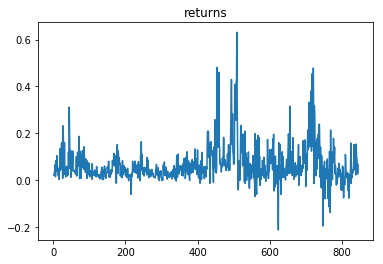

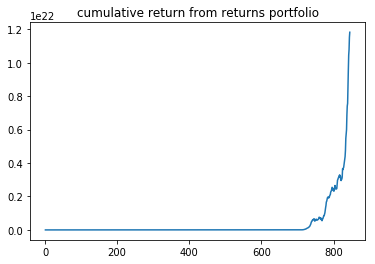

n = 9


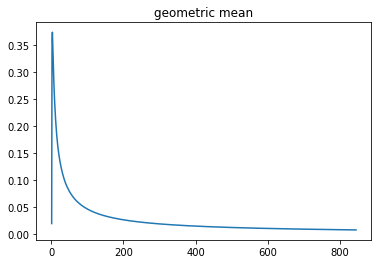

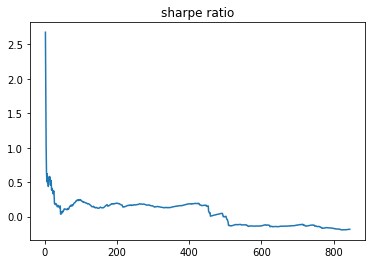

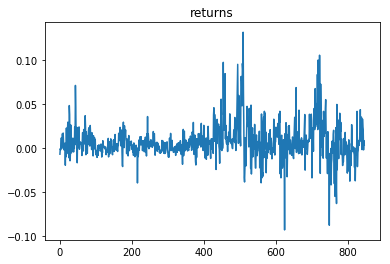

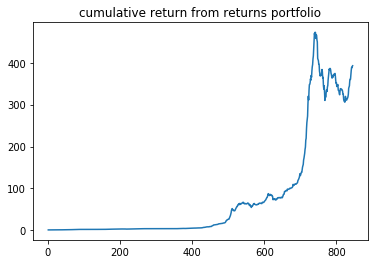

n = 40


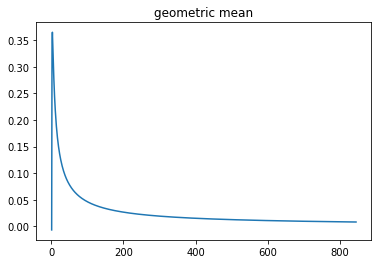

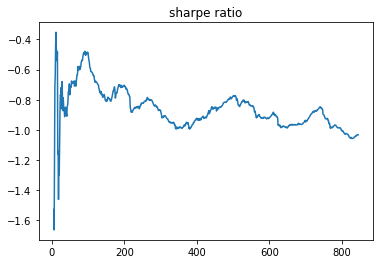

------ w = 7, W_train = 10 -------


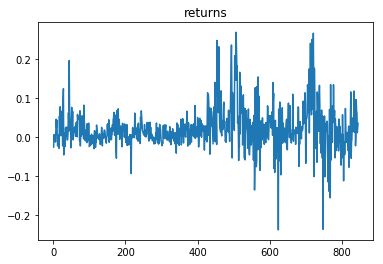

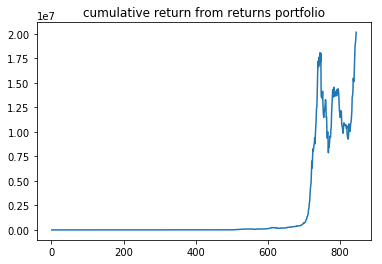

n = 15


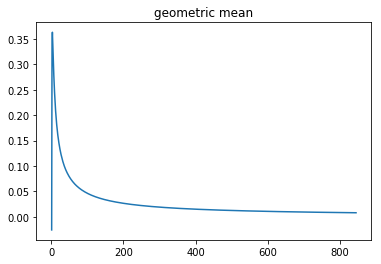

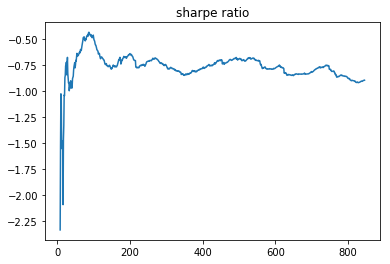

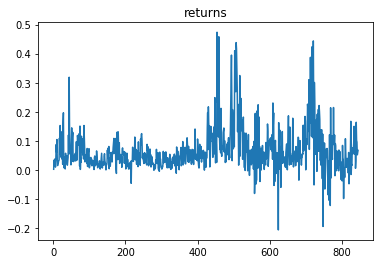

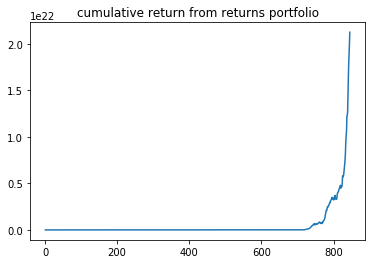

n = 9


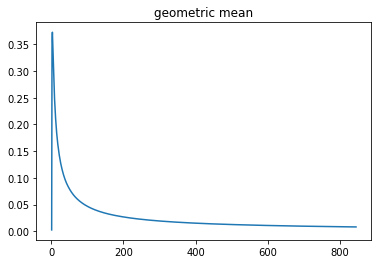

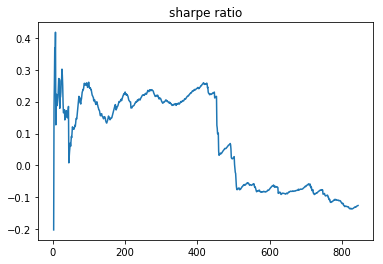

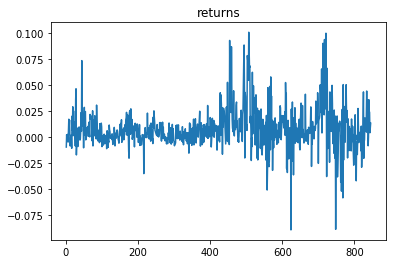

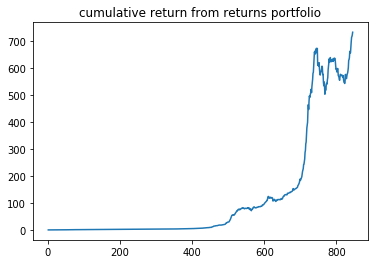

n = 40


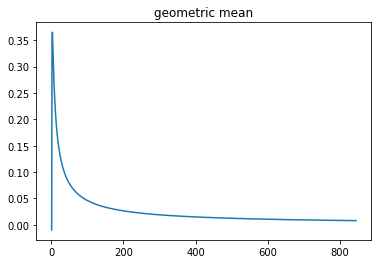

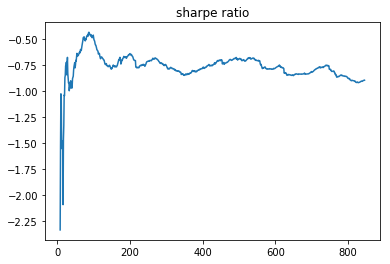

------ w = 7, W_train = 20 -------


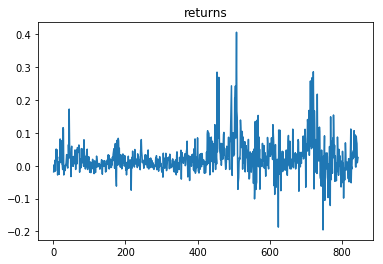

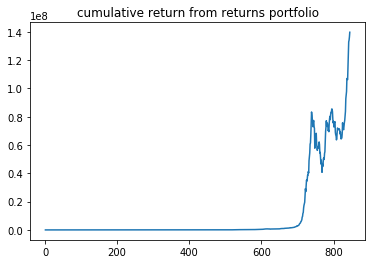

n = 15


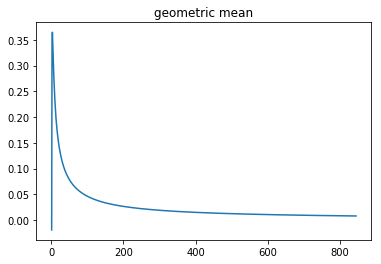

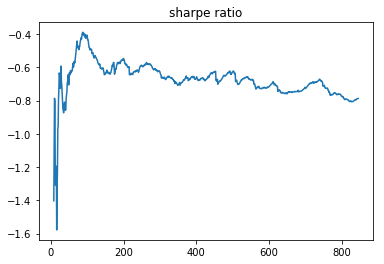

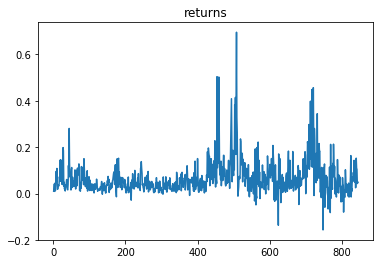

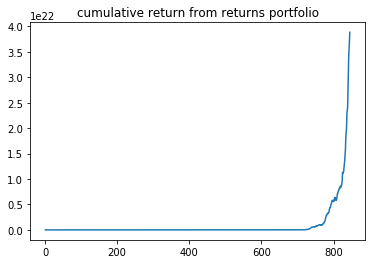

n = 9


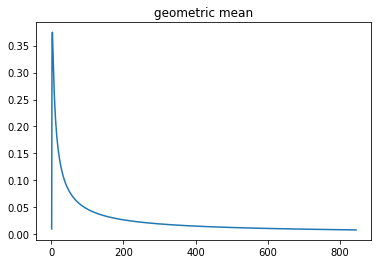

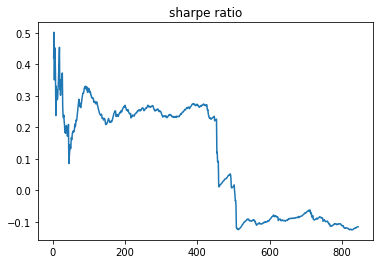

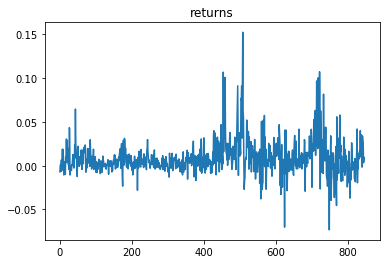

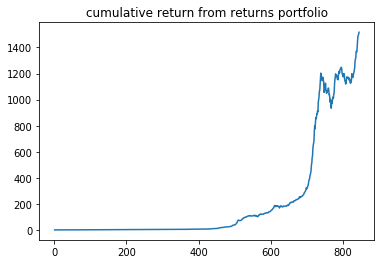

n = 40


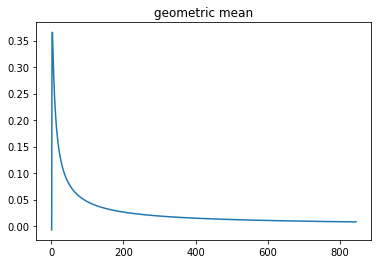

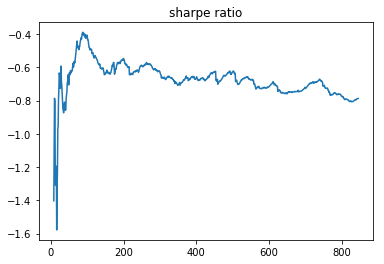

------ w = 10, W_train = 5 -------


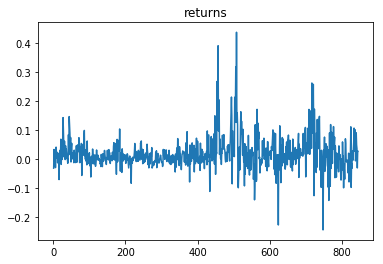

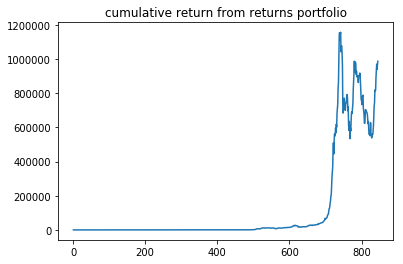

n = 15


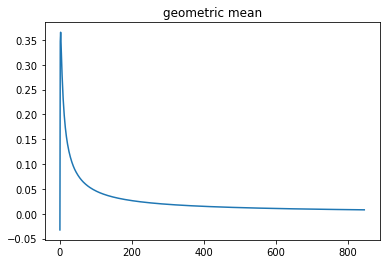

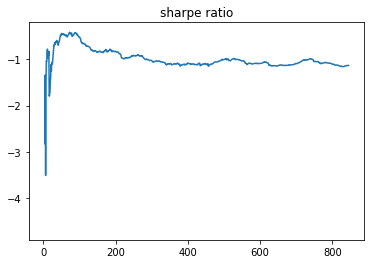

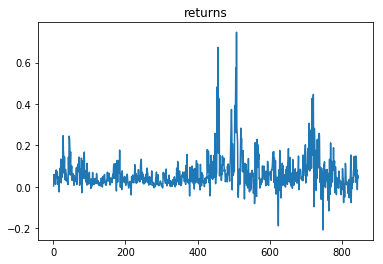

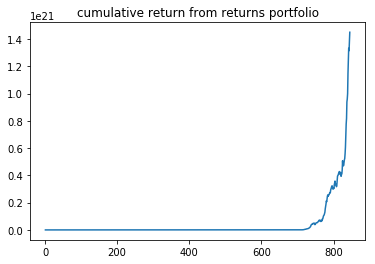

n = 9


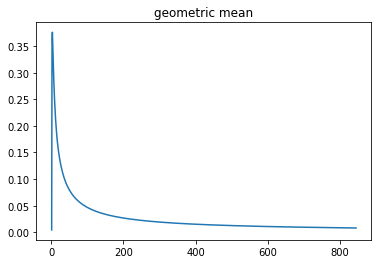

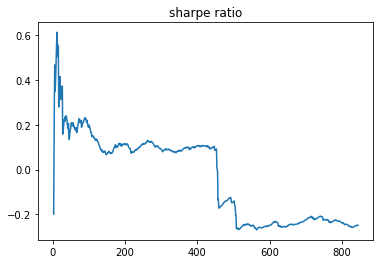

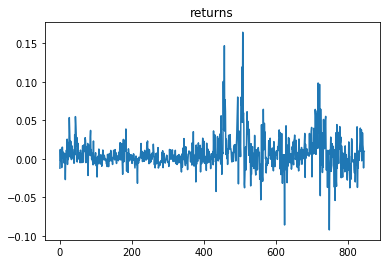

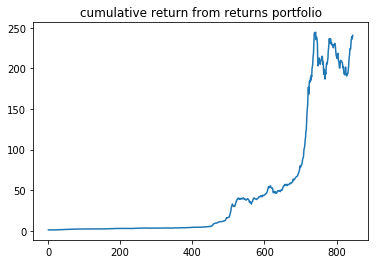

n = 40


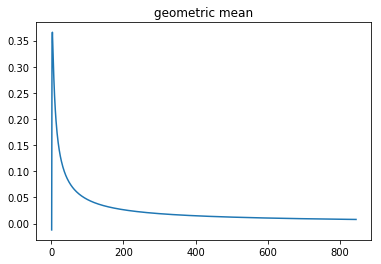

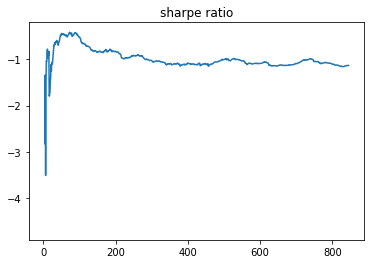

------ w = 10, W_train = 10 -------


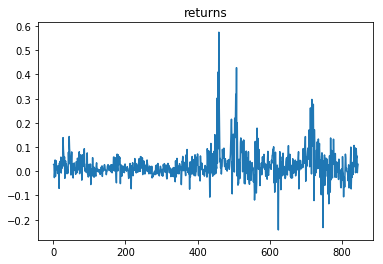

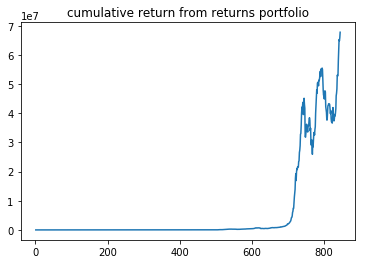

n = 15


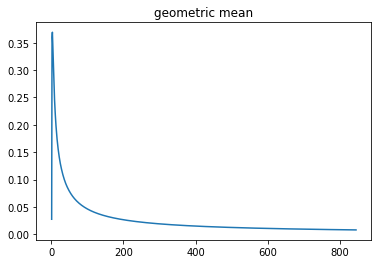

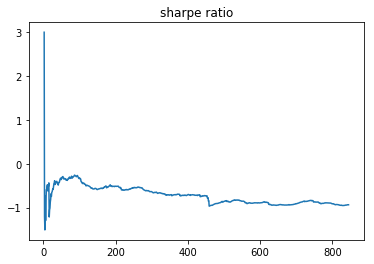

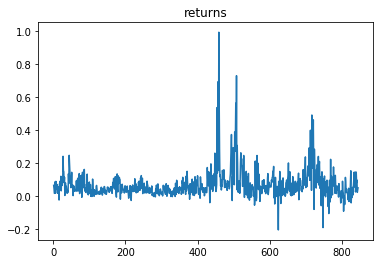

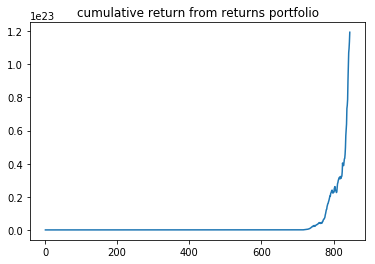

n = 9


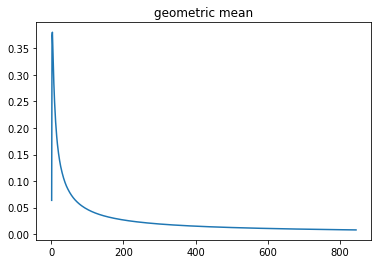

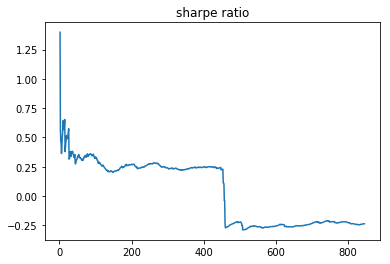

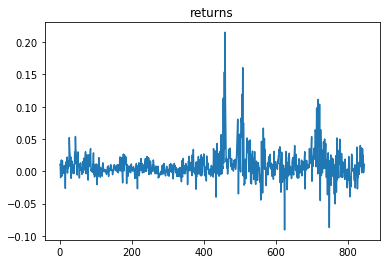

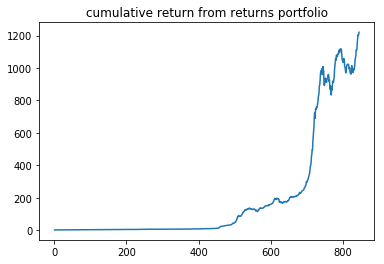

n = 40


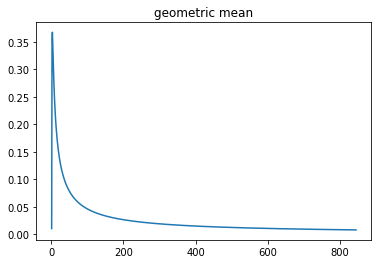

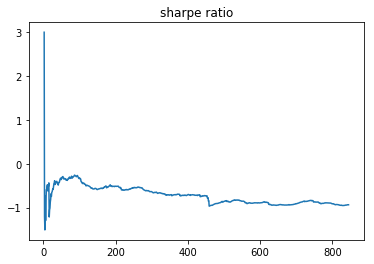

------ w = 10, W_train = 20 -------


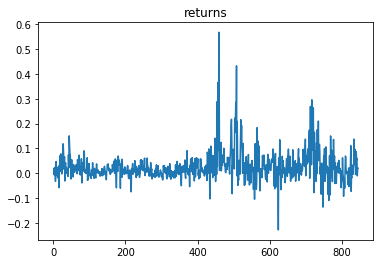

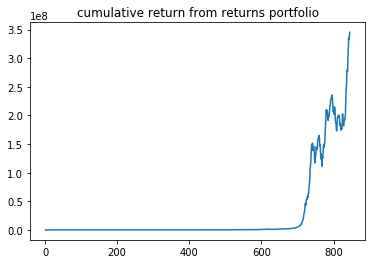

n = 15


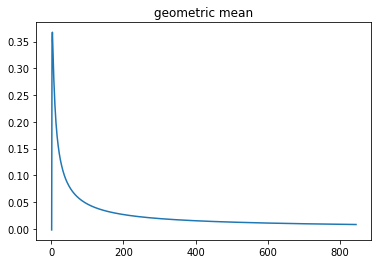

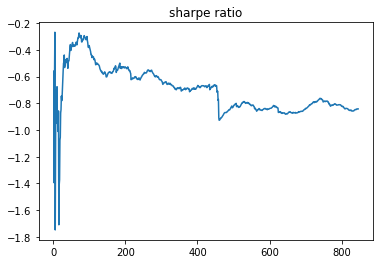

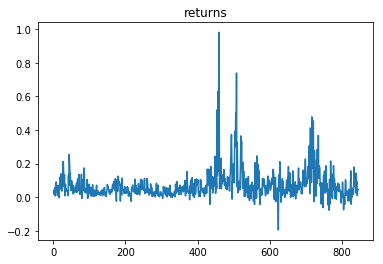

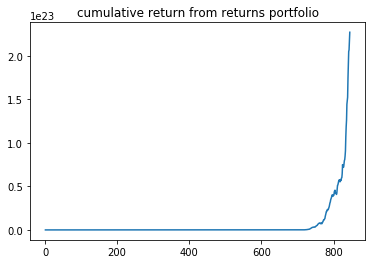

n = 9


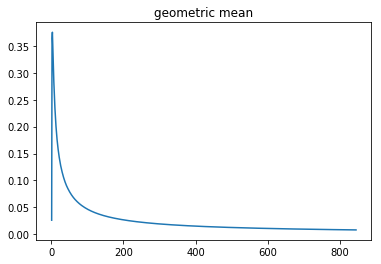

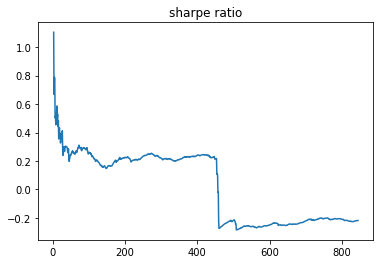

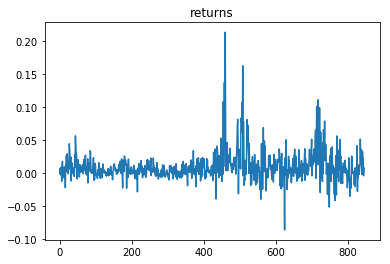

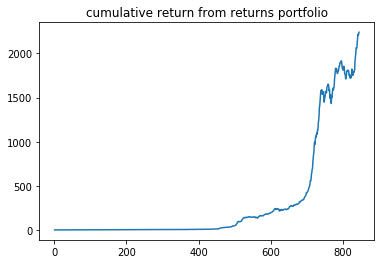

n = 40


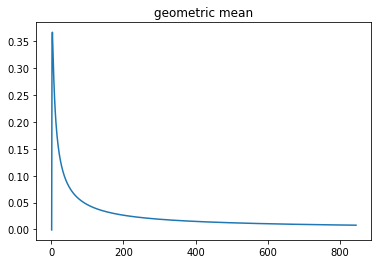

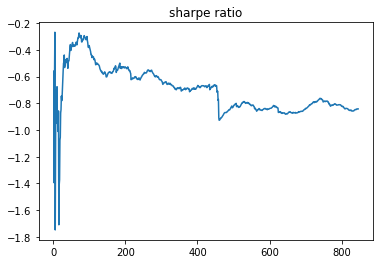

In [0]:
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
import numpy as np

w = [3,5,7,10]
W_train = [5,10,20]

prices2 = pd.read_csv('prices2.csv')
columns = roi.columns.values
num_rows = len(prices2['Time'])
num_currencies = len(columns) - 2
currencies = columns[2:]

currencies_age = pd.read_csv('currency_age.csv')

dataframe_list = []
plt.figure()
rows = -1

for i in w:
  for j in W_train:
    rows += 1
    predict_curr = dict()
    print("------ w = " + str(i) + ", W_train = " + str(j) + " -------")
    used_currencies = []
    time_return = dict()
    for currency in tqdm(currencies[0:100]):
      #if currency == 'tether': continue
      #timeline
      data = pd.DataFrame({'time': dates})
      date_start = datetime.date(2016, 1, 1)
      date_end = datetime.date(2018, 4, 24)
      index_start = data[data['time']==date_start].index.item()
      index_end = data[data['time']==date_end].index.item()
      if not currencies_age[currency][index_start] > 180: 
            #print('pass')
            continue
      #price
      price_std = prices[currency].rolling(window=i).std()
      new_col = pd.DataFrame({'price_std': price_std})
      data = data.join(new_col)
      price_mean = prices[currency].rolling(window=i).mean()
      new_col = pd.DataFrame({'price_mean': price_mean})
      data = data.join(new_col)
      price_med = prices[currency].rolling(window=i).median()
      new_col = pd.DataFrame({'price_median': price_med})
      data = data.join(new_col)

      #marketcaps
      marketcaps_std = marketcaps[currency].rolling(window=i).std()
      new_col = pd.DataFrame({'marketcaps_std': marketcaps_std})
      data = data.join(new_col)
      marketcaps_mean = marketcaps[currency].rolling(window=i).mean()
      new_col = pd.DataFrame({'marketcaps_mean': marketcaps_mean})
      data = data.join(new_col)
      marketcaps_med = marketcaps[currency].rolling(window=i).median()
      new_col = pd.DataFrame({'marketcaps_median': marketcaps_med})
      data = data.join(new_col)

      #marketshares
      marketshares_std = marketshares[currency].rolling(window=i).std()
      new_col = pd.DataFrame({'marketshares_std': marketshares_std})
      data = data.join(new_col)
      marketshares_mean = marketshares[currency].rolling(window=i).mean()
      new_col = pd.DataFrame({'marketshares_mean': marketshares_mean})
      data = data.join(new_col)
      marketshares_med = marketshares[currency].rolling(window=i).median()
      new_col = pd.DataFrame({'marketshares_median': marketshares_med})
      data = data.join(new_col)

      #rank
      rank_std = rank[currency].rolling(window=i).std()
      new_col = pd.DataFrame({'rank_std': rank_std})
      data = data.join(new_col)
      rank_mean = rank[currency].rolling(window=i).mean()
      new_col = pd.DataFrame({'rank_mean': rank_mean})
      data = data.join(new_col)
      rank_med = rank[currency].rolling(window=i).median()
      new_col = pd.DataFrame({'rank_median': rank_med})
      data = data.join(new_col)

      #volume
      volume_std = volumes[currency].rolling(window=i).std()
      new_col = pd.DataFrame({'volume_std': volume_std})
      data = data.join(new_col)
      volume_mean = volumes[currency].rolling(window=i).mean()
      new_col = pd.DataFrame({'volume_mean': volume_mean})
      data = data.join(new_col)
      volume_med = volumes[currency].rolling(window=i).median()
      new_col = pd.DataFrame({'volume_median': volume_med})
      data = data.join(new_col)

      #ROI
      """roi_std = roi[currency].rolling(window=i).std()
      new_col = pd.DataFrame({'ROI_std': roi_std})
      data = data.join(new_col)
      roi_mean = roi[currency].rolling(window=i).mean()
      new_col = pd.DataFrame({'ROI_mean': roi_mean})
      data = data.join(new_col)
      roi_med = roi[currency].rolling(window=i).median()
      new_col = pd.DataFrame({'ROI_median': roi_med})
      data = data.join(new_col)"""

      #target
      new_col = pd.DataFrame({'target': roi[currency]})
      data = data.join(new_col)

      # ----- TRAIN -----
      date_start = datetime.date(2016, 1, 1)
      date_end = datetime.date(2018, 4, 24)
      index_start = data[data['time']==date_start].index.item()
      index_end = data[data['time']==date_end].index.item()
      #print(index_end)
      X = data.loc[: , 'price_std' : 'volume_median']
      Y = data['target']

      #if volumes[currency][index_start : index_end+1].any() < 100000: continue
      if not currencies_age[currency][index_start] > 150: continue
      model = xgb.XGBRegressor(n_jobs = 8)
      predicted = []; true = [];
      loss_suma = 0
      count = 0
      time = []
      used_currencies.append(currency)
      for t in range(index_start, index_end+1):
        count += 1
        if count >= 1: time.append(count)
        X_train, X_test = X.loc[t - j : t-1], X.loc[[t]]
        Y_train, Y_test = Y.loc[t - j : t-1], Y.loc[t]
        clf = model
        clf.fit(X_train, Y_train)
        y_pred = clf.predict(X_test)
        y_p = np.take(y_pred,0)
        y_t = float(np.take(Y_test,0))
        if currency=='bitcoin':
          time_return[t] = []
          time_return[t].append(y_p)
        else:
          time_return[t].append(y_p)
        predicted.append(y_p)
        true.append(y_t)
        #loss = mean_squared_error([y_t], [y_p])
        #loss_suma += loss
      if count == 0: continue
      #avg_loss = float(loss_suma/count)
      #print("Average Loss for c = " + currency + " and W_train = " + str(j) + ", w = " + str(i) + " is: " + str(avg_loss))
      predict_curr[currency] = predicted
    
    predicted_for_day = sort_highest_return(time_return, 15)
    sharpe = sharpe_ratio(predicted_for_day, index_end - index_start+1, 15)
    geo = geometric_mean(predicted_for_day, index_end - index_start+1, time, 15)
    print("n = " + str(15))
    #print("Sharpe ratio: " + str(sharpe))
    #print("Geometric mean: " + str(geo))
    plt.plot(time, np.log(geo))
    plt.title("geometric mean")
    plt.show()
    plt.plot(time, np.log(sharpe))
    plt.title("sharpe ratio")
    plt.show()
    
    predicted_for_day = sort_highest_return(time_return, 9)
    sharpe = sharpe_ratio(predicted_for_day, index_end - index_start+1, 9)
    geo = geometric_mean(predicted_for_day, index_end - index_start+1, time, 9)
    
    print("n = " + str(9))
    #print("Sharpe ratio: " + str(sharpe))
    #print("Geometric mean: " + str(geo))
    plt.plot(time, np.log(geo))
    plt.title("geometric mean")
    plt.show()
    plt.plot(time, np.log(sharpe))
    plt.title("sharpe ratio")
    plt.show()
    
    predicted_for_day = sort_highest_return(time_return, 40)
    sharpe = sharpe_ratio(predicted_for_day, index_end - index_start+1, 40)
    geo = geometric_mean(predicted_for_day, index_end - index_start+1, time, 40)
    
    print("n = " + str(40))
    #print("Sharpe ratio: " + str(sharpe))
    #print("Geometric mean: " + str(geo))
    plt.plot(time, np.log(geo))
    plt.title("geometric mean")
    plt.show()
    plt.plot(time, np.log(sharpe))
    plt.title("sharpe ratio")
    plt.show()

---- baseline ----
---- w = 3 ------
Average Loss for c = bitcoin, w = 3 is: 1.4167662170805794e-06


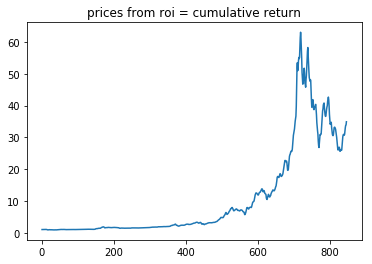

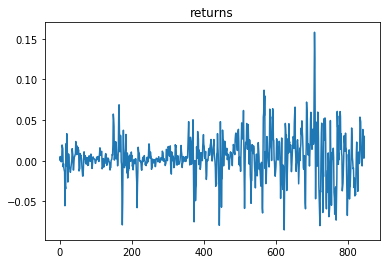

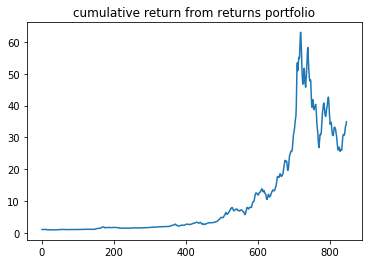

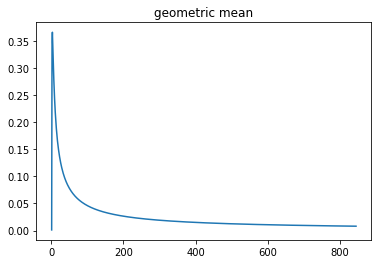

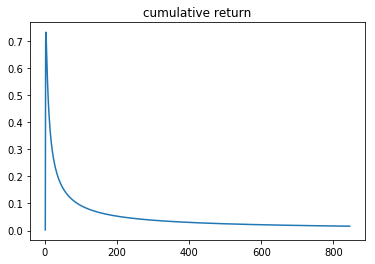

---- w = 4 ------
Average Loss for c = bitcoin, w = 4 is: 1.5831565409667554e-06


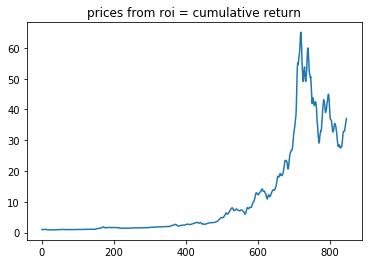

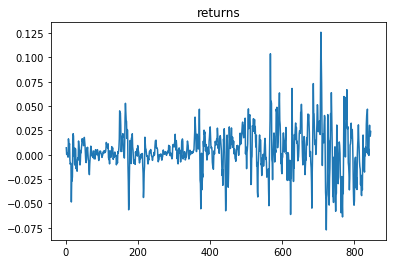

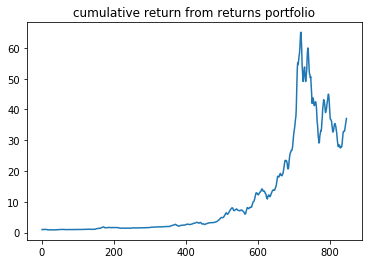

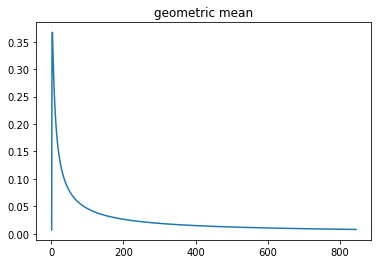

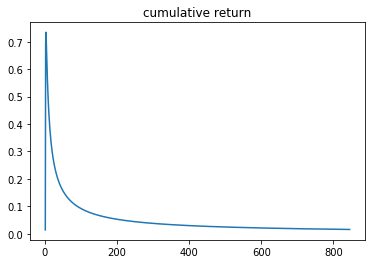

---- w = 5 ------
Average Loss for c = bitcoin, w = 5 is: 1.7225206298952243e-06


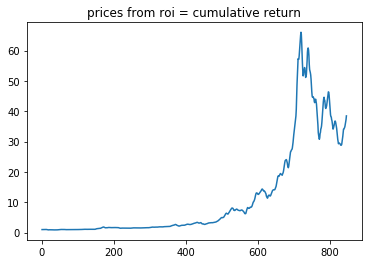

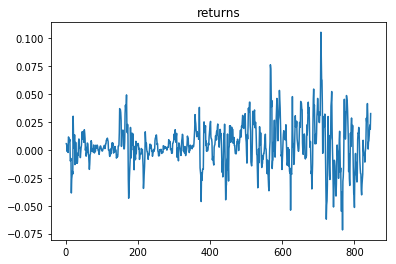

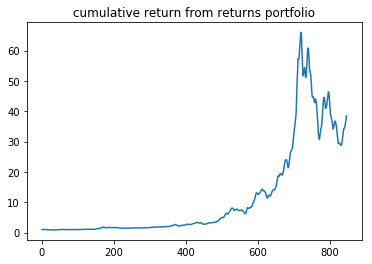

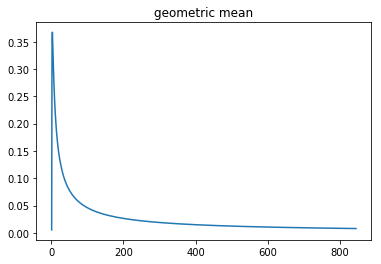

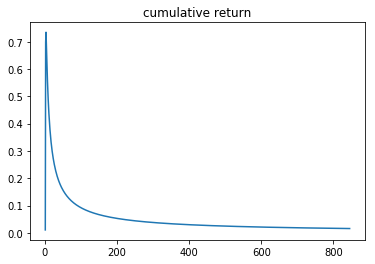

---- w = 6 ------
Average Loss for c = bitcoin, w = 6 is: 1.7761737043725312e-06


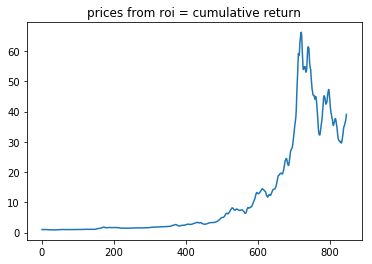

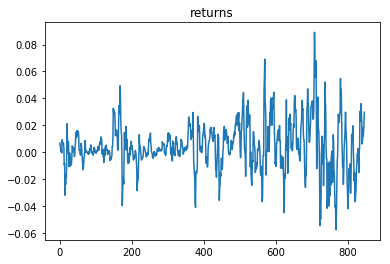

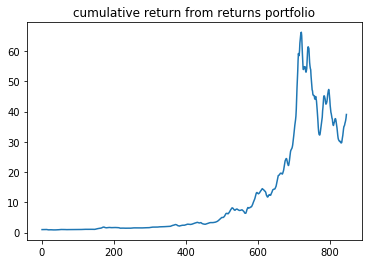

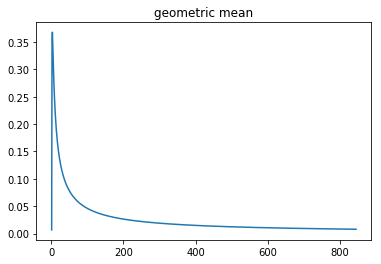

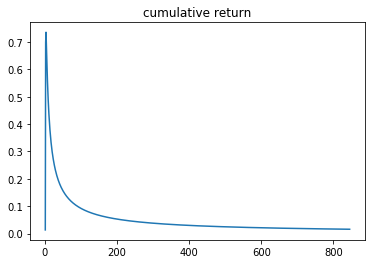

---- w = 7 ------
Average Loss for c = bitcoin, w = 7 is: 1.8112389404928194e-06


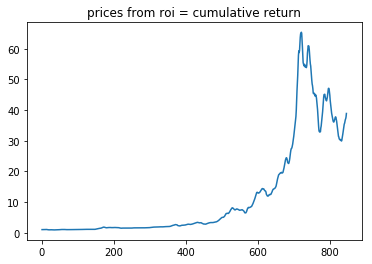

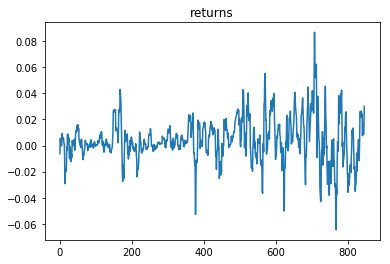

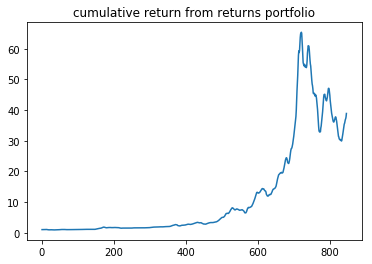

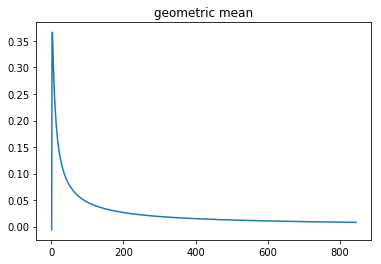

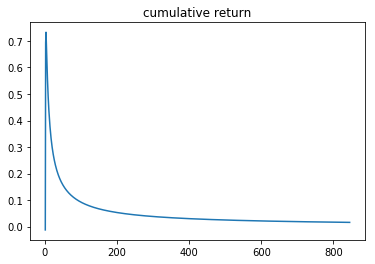

---- w = 8 ------
Average Loss for c = bitcoin, w = 8 is: 1.8622997129487114e-06


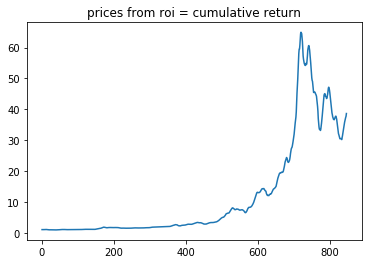

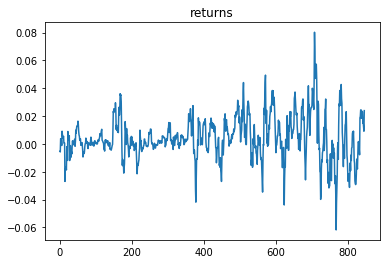

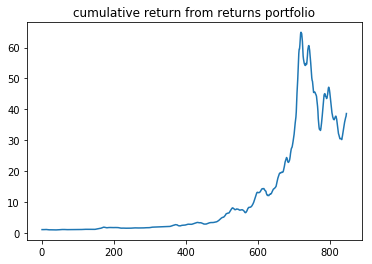

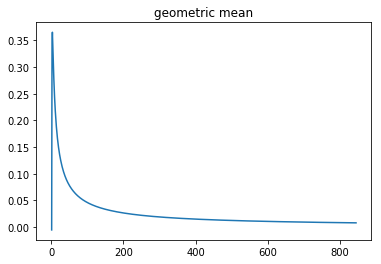

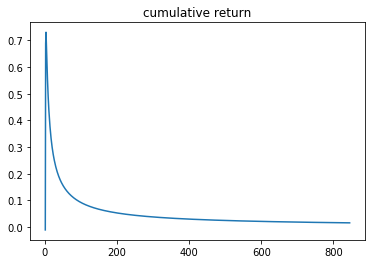

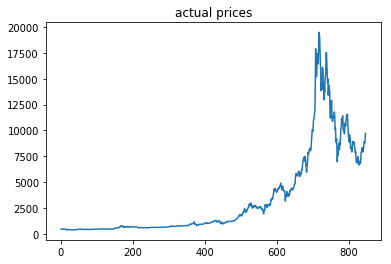

In [0]:
# baseline
print("---- baseline ----")
w = [3,4,5,6,7,8]
#columns = prices2.columns.values
num_rows = len(prices['Time'])
num_currencies = len(columns) - 2
#currencies = columns[2:]
currencies_age = pd.read_csv('currency_age.csv')
age_bitcoin = currencies_age['bitcoin']

plt.figure()

for i in w:
  print("---- w = " + str(i) + " ------")
  predict_curr = dict()
  time = []; bitcoin_prices=[];
  if age_bitcoin[index_start] > 50:
    y_predicted = roi['bitcoin'].rolling(window=i).mean()
    prices_b = prices['bitcoin']
    y_true = roi['bitcoin']
    y_p=[]; y_t=[]; count = 0;
    for t in range(index_start, index_end+1):
        count += 1
        bitcoin_prices.append(prices_b[t])
        time.append(count)
        y_p.append(y_predicted[t])
        y_t.append(y_true[t])
        predict_curr[t] = []
        predict_curr[t].append(y_predicted[t])
    if count == 0: continue
    loss = (1/count)*mean_squared_error(y_t, y_p)
    print("Average Loss for c = bitcoin, w = " + str(i) + " is: " + str(loss))
  prices_from_roi = currency_price(y_p, time)
  plt.plot(time, prices_from_roi)
  plt.title("prices from roi = cumulative return")
  plt.show()
  #sharpe = sharpe_ratio(predict_curr, index_end - index_start+1)
  geo = geometric_mean(predict_curr, index_end - index_start+1, time, 1)
  #print("Sharpe ratio: " + str(sharpe))
  #print("Geometric mean: " + str(geo))
  plt.plot(time, np.log(geo))
  plt.title("geometric mean")
  plt.show()
  cumulative_return = np.power(geo, 2)
  #print("Cumulative return: " + str(cumulative_return))
  plt.plot(time, np.log(cumulative_return))
  plt.title("cumulative return")
  plt.show()
  
plt.plot(time, bitcoin_prices)
plt.title("actual prices")

plt.show()
      

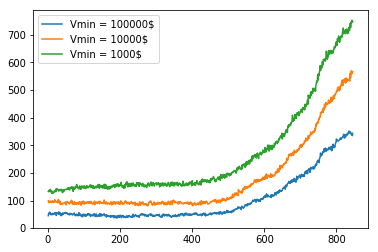

In [0]:

day_count_1=[]; time=[];
day_count_2=[]; day_count_3=[];
for i in tqdm(range(index_start, index_end+1)):
  count_1 = 0; count_2 = 0; count_3 = 0;
  time.append(i - index_start + 1)
  for currency in currencies:
    if volumes[currency][i] > 100000:
      count_1 += 1
    if volumes[currency][i] > 10000:
      count_2 += 1
    if volumes[currency][i] > 1000:
      count_3 += 1
  day_count_1.append(count_1)
  day_count_2.append(count_2)
  day_count_3.append(count_3)

plt.figure()
plt.plot(time, day_count_1, label="Vmin = 100000$")
plt.plot(time, day_count_2, label="Vmin = 10000$")
plt.plot(time, day_count_3, label="Vmin = 1000$")
plt.legend()